# UChicago - ML2 Final Project
# Author: Akanksha Mathpati, Chris Tomaszkiewicz, Deepali Dagar, Sakshi Bokil
## <b> Objective 2: Multi-Label Job Domain Classifier
### Predict multiple job domains using extracted skills from job descriptions with NLP and ML techniques.


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
cd /content/drive/MyDrive/UOC/ML2/Resume dataset/

/content/drive/MyDrive/UOC/ML2/Resume dataset


In [169]:
ls

 app.py              job1.jpg                      models_bundle/
 cleaned_data.csv    job_embeddings.npy            models_bundle.zip
 combined_data.csv   jobs/                         nlp_custom/
 companies/         'jobseeker (1).jpg'            postings.csv
'employer (1).jpg'  'jobseeker (2).jpg'            Resume.csv
'employer (2).jpg'  'jobseeker (3).jpg'            resume_embeddings.npy
'employer (3).jpg'   jobseeker.jpg                 Resume-job/
 employer.jpg        mappings/                     sbert_model/
 illustration.jpeg   matcher.pkl                   vectorizer.pkl
 integrated_app.py   mlb.pkl                       xgb_model.pkl
'job1 (1).jpg'       ML_Project_classifier.ipynb


## Import Libraries

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import spacy
import joblib
import nltk

## LOAD DATASETS

In [ ]:
postings_df = pd.read_csv('postings.csv')
resume_df = pd.read_csv('Resume.csv')

In [ ]:
postings_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [ ]:
postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [ ]:
postings_df['posting_domain'].unique()

array([nan, 'arrowstaffingservices.thejobnetwork.com',
       'williamsleagroupltd.thejobnetwork.com', ..., 'www.opswat.com',
       'imec.csod.com', 'epsoperations.bamboohr.com'], dtype=object)

In [ ]:
postings_df.shape

(123849, 31)

In [ ]:
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [ ]:
resume_df.shape

(2484, 4)

In [ ]:
postings_sample_df = postings_df.sample(3000, random_state=42).copy()
resume_sample_df = resume_df

## <b> TEXT PREPROCESSING

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Define lists of skills and job domains to extract from text
SKILLS = ['javascript', 'node.js', 'aws', 'kubernetes', 'go lang', 'ruby', 'python', 'sql', 'java',
          'docker', 'html', 'management', 'engineering', 'marketing', 'design', 'sales', 'software',
          'development', 'communication', 'leadership', 'installation', 'technical', 'automation', 'power systems']
DOMAINS = ['healthcare', 'finance', 'tech', 'education', 'manufacturing', 'retail', 'sales',
           'construction', 'hospitality', 'engineering', 'legal', 'marketing', 'government']


In [ ]:
# Function to preprocess job text
def preprocess_text(text):
    if pd.isna(text): return ""
    doc = nlp(text.lower())
    original_terms = [token.text for token in doc]
    lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return {'original': original_terms, 'lemmatized': lemmatized}

# Function to extract known skills from text
def extract_skills(text_data):
    if not isinstance(text_data, dict): return []
    return [skill for skill in SKILLS if any(skill in term for term in text_data['original'])]

# Function to infer job domains from text and skills
def extract_domains(text_data, skills=None):
    if not isinstance(text_data, dict): return []
    original_terms = text_data['original']
    domains = [domain for domain in DOMAINS if any(domain in term for term in original_terms)]
    if skills:
        if any(skill in skills for skill in ['aws', 'kubernetes', 'docker']):
            domains.append('tech')
        if any(skill in skills for skill in ['management', 'leadership']):
            domains.append('business')
    return list(set(domains))

In [ ]:
# Apply preprocessing functions to job postings
postings_sample_df['processed_desc'] = postings_sample_df['description'].apply(preprocess_text)
postings_sample_df['job_skills'] = postings_sample_df['processed_desc'].apply(extract_skills)
postings_sample_df['job_domain'] = postings_sample_df.apply(lambda x: extract_domains(x['processed_desc'], x['job_skills']), axis=1)

## COMBINE & CLEAN DATA

In [ ]:
# Clean and prepare the dataset for modeling
combined_data = postings_sample_df[['job_id', 'title', 'processed_desc', 'job_skills', 'job_domain']].copy()
combined_data['job_skills'] = combined_data['job_skills'].apply(lambda x: x if isinstance(x, list) else [])
combined_data['job_domain'] = combined_data['job_domain'].apply(lambda x: x if isinstance(x, list) else [])
combined_data['skill_text'] = combined_data['job_skills'].apply(lambda x: ' '.join(x))


In [ ]:
combined_data.head()

,job_id,title,processed_desc,job_skills,job_domain,skill_text
73989,3902944011,Senior Automation Engineer - Power Systems,"{'original': ['the', 'senior', 'automation', '...","[engineering, design, development, communicati...","[engineering, tech]",engineering design development communication a...
59308,3901960222,DISH Installation Technician - Field,"{'original': ['company', 'summary', ' ', 'dis...","[leadership, installation]","[tech, business]",leadership installation
44663,3900944095,Order Builder,"{'original': ['division', ':', 'north', 'alaba...",[management],"[tech, education, business]",management
81954,3903878594,"Mountain Multimedia Journalist, KMGH","{'original': ['kmgh', ',', 'the', 'e.w', '.', ...","[aws, leadership]","[tech, business]",aws leadership
113151,3905670593,Licensed Practical Nurse (LPN),"{'original': ['come', 'for', 'the', 'flexibili...",[aws],[tech],aws


In [ ]:
combined_data.isnull().sum()

,0
job_id,0
title,0
processed_desc,0
job_skills,0
job_domain,0
skill_text,0


## <b> What are the most common job domains?

<ipython-input-60-6aa8412d8fca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=domain_counts, order=domain_counts.value_counts().index, palette="crest")


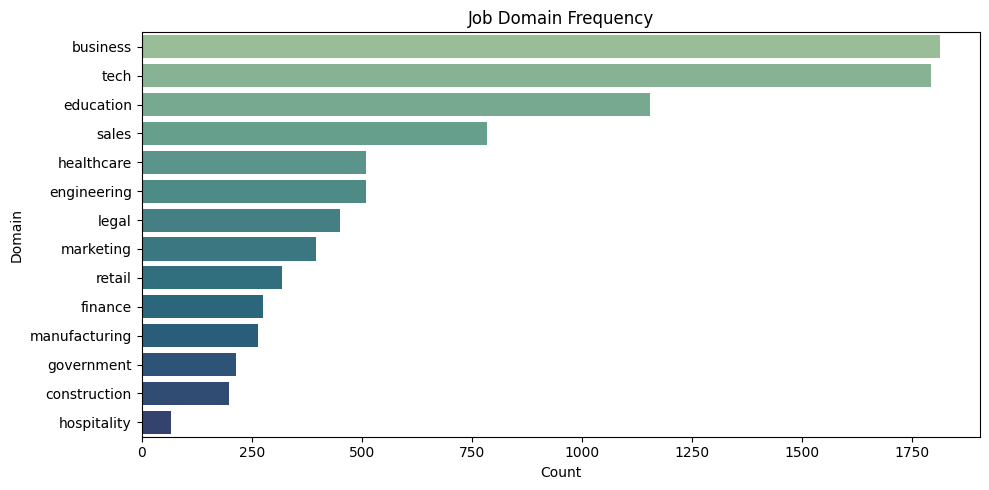

In [ ]:
# Ensure all values in job_domain are lists
combined_data['job_domain'] = combined_data['job_domain'].apply(lambda x: x if isinstance(x, list) else [])

domain_counts = pd.Series([d for sublist in combined_data['job_domain'] for d in sublist])

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(y=domain_counts, order=domain_counts.value_counts().index, palette="crest")
plt.title("Job Domain Frequency")
plt.xlabel("Count")
plt.ylabel("Domain")
plt.tight_layout()
plt.show()


In [ ]:

print(type(combined_data['job_skills']))


<class 'pandas.core.series.Series'>


## LABEL BINARIZATION

In [ ]:
# Convert list of job domains into multi-hot encoded format
combined_data['job_domain'] = combined_data['job_domain'].apply(
    lambda x: x if isinstance(x, list) else []
)

y_raw = mlb.fit_transform(combined_data['job_domain'])



In [ ]:
# Address class imbalance using class weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer

# Compute weights for each class
class_weights = {}
for i, class_name in enumerate(mlb.classes_):
    binary_labels = y_raw[:, i]
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=binary_labels
    )
    class_weights[i] = {0: weights[0], 1: weights[1]}

y = y_raw

In [ ]:
print(combined_data[['job_skills', 'skill_text']].head())


                                               job_skills  \
73989   [engineering, design, development, communicati...   
59308                          [leadership, installation]   
44663                                        [management]   
81954                                   [aws, leadership]   
113151                                              [aws]   

                                               skill_text  
73989   engineering design development communication a...  
59308                             leadership installation  
44663                                          management  
81954                                      aws leadership  
113151                                                aws  


## TF-IDF FEATURE EXTRACTION

In [ ]:
# Convert skill text into TF-IDF features
vectorizer = TfidfVectorizer(binary=True)
X = vectorizer.fit_transform(combined_data['skill_text'])

## TRAIN-TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <b>Compare models</b>
GRID SEARCH: MODEL TUNING

In [ ]:
# Tune multiple models and store best estimators
tuned_models = {}

 ## **XGBoost**

In [ ]:
param_xgb = {'estimator__n_estimators': [100, 200], 'estimator__max_depth': [3, 5], 'estimator__learning_rate': [0.05, 0.1]}
grid_xgb = GridSearchCV(OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')), param_grid=param_xgb, cv=3, scoring='f1_micro', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
tuned_models['XGBoost'] = grid_xgb.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:56:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

## **Logistic Regression**

In [ ]:
param_logreg = {'estimator__C': [0.1, 1, 10], 'estimator__penalty': ['l2'], 'estimator__solver': ['lbfgs']}
grid_logreg = GridSearchCV(OneVsRestClassifier(LogisticRegression(max_iter=1000)), param_grid=param_logreg, cv=3, scoring='f1_micro', n_jobs=-1)
grid_logreg.fit(X_train, y_train)
tuned_models['Logistic Regression'] = grid_logreg.best_estimator_

## **Random Forest**

In [ ]:
param_rf = {'estimator__n_estimators': [100, 200], 'estimator__max_depth': [None, 20], 'estimator__min_samples_split': [2, 5]}
grid_rf = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()), param_grid=param_rf, cv=3, scoring='f1_micro', n_jobs=-1)
grid_rf.fit(X_train, y_train)
tuned_models['Random Forest'] = grid_rf.best_estimator_

## **Naive Bayes**

In [ ]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(X_train, y_train)
tuned_models['Naive Bayes'] = nb

In [ ]:
tuned_models

{'XGBoost': OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric='logloss',
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.05, max_bin=None,
                                             max_cat_threshol

## <b> MODEL COMPARISON


XGBoost Report:

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       362
 construction       0.00      0.00      0.00        35
    education       0.50      0.28      0.36       222
  engineering       1.00      1.00      1.00       105
      finance       0.42      0.10      0.16        50
   government       0.00      0.00      0.00        41
   healthcare       0.33      0.02      0.04        86
  hospitality       0.00      0.00      0.00        15
        legal       0.25      0.01      0.02        94
manufacturing       0.46      0.09      0.15        65
    marketing       1.00      1.00      1.00        73
       retail       0.56      0.18      0.28        76
        sales       1.00      1.00      1.00       170
         tech       0.91      0.70      0.79       356

    micro avg       0.89      0.60      0.72      1750
    macro avg       0.53      0.39      0.42      1750
 weighted avg       0.74      0.60      0.64 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


Random Forest Report:

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       362
 construction       0.00      0.00      0.00        35
    education       0.45      0.31      0.37       222
  engineering       1.00      1.00      1.00       105
      finance       0.27      0.06      0.10        50
   government       0.19      0.07      0.11        41
   healthcare       0.32      0.08      0.13        86
  hospitality       0.00      0.00      0.00        15
        legal       0.28      0.05      0.09        94
manufacturing       0.50      0.12      0.20        65
    marketing       1.00      1.00      1.00        73
       retail       0.52      0.16      0.24        76
        sales       1.00      1.00      1.00       170
         tech       0.88      0.73      0.80       356

    micro avg       0.85      0.62      0.71      1750
    macro avg       0.53      0.40      0.43      1750
 weighted avg       0.73      0.62     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

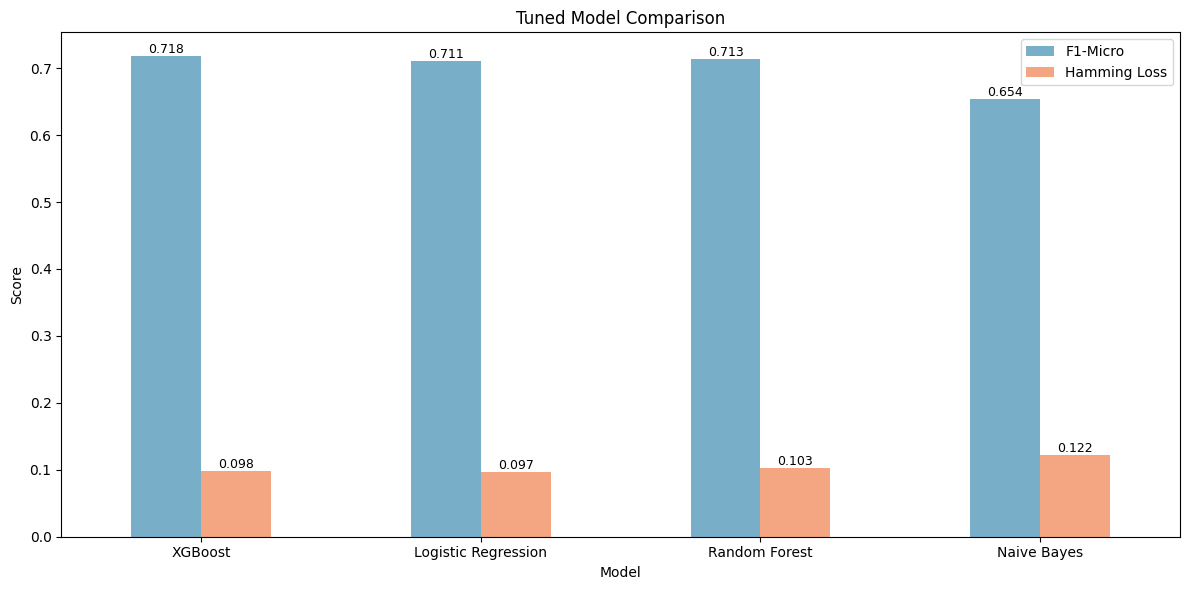

In [ ]:
# Evaluate and compare model performance across multiple metrics
results = []
for name, model in tuned_models.items():
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1_micro = f1_score(y_test, pred, average='micro')
    h_loss = hamming_loss(y_test, pred)
    results.append({'Model': name, 'Subset Accuracy': acc, 'F1-Micro': f1_micro, 'Hamming Loss': h_loss})
    print(f"\n{name} Report:\n")
    print(classification_report(y_test, pred, target_names=mlb.classes_))

# Plot model comparison - Focused on F1-Micro and Hamming Loss
results_df = pd.DataFrame(results)
ax = results_df.set_index('Model')[['F1-Micro', 'Hamming Loss']].plot(kind='bar', figsize=(12,6), title='Tuned Model Comparison', rot=0, color=['#79aec8', '#f4a582'])
plt.ylabel('Score')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()

XGBoost is the best-balanced model for this multi-label classification task, with strong scores across accuracy, precision/recall, and error rate.

In [ ]:
results_df

,Model,Subset Accuracy,F1-Micro,Hamming Loss
0,XGBoost,0.245000,0.717651,0.098452
1,Logistic Regression,0.226667,0.710685,0.097024
2,Random Forest,0.235000,0.713291,0.102976
3,Naive Bayes,0.160000,0.653859,0.122262


## <b> SAMPLE PREDICTION

In [ ]:
sample_skills = ['python', 'aws', 'leadership', 'docker', 'sql']
sample_vector = vectorizer.transform([' '.join(sample_skills)])
for name, model in tuned_models.items():
    pred_bin = model.predict(sample_vector)
    pred_labels = mlb.inverse_transform(pred_bin)
    print(f"{name} Prediction -> {pred_labels}")

XGBoost Prediction -> [('business', 'tech')]
Logistic Regression Prediction -> [('business', 'tech')]
Random Forest Prediction -> [('business', 'tech')]
Naive Bayes Prediction -> [('business', 'tech')]


## <b> EXPORT MODELS

In [ ]:
import joblib
# Save the best-performing model and associated transformers for deployment
joblib.dump(tuned_models['XGBoost'], 'xgb_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(mlb, 'mlb.pkl')

In [ ]:
from google.colab import files

files.download('xgb_model.pkl')
files.download('vectorizer.pkl')
files.download('mlb.pkl')


In [ ]:
!zip models_bundle.zip xgb_model.pkl vectorizer.pkl mlb.pkl
files.download('models_bundle.zip')
